In [1]:
import pandas as pd
import pytz
import smtplib 
from stockstats import StockDataFrame
from datetime import datetime
import datetime as dt
from IPython.display import clear_output
import time
import numpy as np
import matplotlib.pyplot as py
import urllib3
import plotly.graph_objects as go
from binance.client import Client

In [2]:
def convert_datetime_timezone(dt, tz1, tz2):
    tz1 = pytz.timezone(tz1)
    tz2 = pytz.timezone(tz2)
    dt = datetime.strptime(dt,'%Y-%m-%d %H:%M:%S')
    dt = tz1.localize(dt)
    dt = dt.astimezone(tz2)
    dt = dt.strftime('%Y-%m-%d %H:%M:%S')
    return dt

In [3]:
def scrap_binance_price(unit,interval):
    from binance.client import Client
    import pandas as pd
    import datetime
    import dateutil.parser

    api_key = 'LKa422RMjzx2tsXESIoSQ5qJzqi7LaC7iDFf9qdSrYjhJrZ6a8CcvOdniJWtfX13'
    api_secret = 'EvomPthpqwgTjeuqYFWBQM9HtE52Zeq6SuKrZSROqhd8g2tvbz086zVZqbbJGxsZ'

    client = Client(api_key, api_secret, {"verify": False, "timeout": 20})
    klines = client.get_historical_klines("BTCUSDT", unit, interval)

    data = pd.DataFrame();
    tradingdate = []
    openprice = []
    highprice = []
    lowprice = []
    closeprice = [] 
    for i in range(len(klines)):   
        time = datetime.datetime.utcfromtimestamp(klines[i][0]/1000).strftime('%Y-%m-%d %H:%M:%S')
        local_time = convert_datetime_timezone(time,'GMT','Australia/Adelaide')
        format_time = dateutil.parser.parse(local_time)
        tradingdate.append(format_time)
        openprice.append(float(klines[i][1]))
        highprice.append(float(klines[i][2]))
        lowprice.append(float(klines[i][3]))
        closeprice.append(float(klines[i][4]))
    data['datetime'] = tradingdate
    data['low'] = lowprice
    data['high'] = highprice
    data['open'] = openprice
    data['close'] = closeprice
    return data

In [4]:
def add_indicator(df):
    from stockstats import StockDataFrame
    df.reset_index(drop=True, inplace=True)
    df = StockDataFrame.retype(df)
    df['macd'] = df.get('macd') # calculate MACD
    #1: buy indicator
    #-1: sell indicator
    #0: no activity
    MACD = df
    point = []
    previous = 0
    current = 0
    #MACD_EMA_SHORT: default to 12
    #MACD_EMA_LONG: default to 26
    #MACD_EMA_SIGNAL: default to 9
    point.append(0)
    hasBitcoin = False
    for i in range(1,len(MACD)):
        previous = MACD['macdh'][i-1];
        current = MACD['macdh'][i];
        if(previous<0 and current >0 and hasBitcoin == False):
            point.append(1)
            hasBitcoin = True
        elif(previous>0 and current <0 and hasBitcoin == True):
            point.append(2)
            hasBitcoin = False
        else:
            point.append(0)
    MACD['indicator'] = point
    return MACD

In [5]:
def round_down(value, decimals):
    factor = 1 / (10 ** decimals)
    return (value // factor) * factor


In [6]:
def email_notification(message):
    info = pd.read_csv('C:\\Users\\Ray\\Desktop\\E_Info.csv')
    gmailaddress = info['username'][0]
    gmailpassword = info['password'][0]
    mailToOne = info['addressOne'][0]
    mailToTwo = info['addressTwo'][0]
    msg = "Buy the Bitcoin"
    mailServer = smtplib.SMTP('smtp.gmail.com' , 587)
    mailServer.starttls()
    mailServer.login(gmailaddress , gmailpassword)
    #mailServer.sendmail(gmailaddress, mailToOne , message)
    #mailServer.sendmail(gmailaddress, mailToTwo , message)
    mailServer.quit()

In [7]:
def trading(treasure,test,money,bitcoin,bnb):
    
    initial_money = money
    initial_bitcoin = bitcoin
    initial_bnb = bnb
    #client.order_market_buy(symbol = 'BTCUSDT',quantity = round_down(initial_bnb,6))
    A = []
    B = []
    C = []
    D = []
    E = []
    F = []
    G = []
    
    commission_rate = 0.00075
    
    test.reset_index(drop = True, inplace = True)
    comission_state = True
    balance = 100
    index = 0
    for i in range (len(test)):
        #set the current transfer index    
        index += 1
        #set the transaction rule
        #set the rule of buy bitcoin
        if(test['indicator'][i] == 1 and money > 0 and comission_state == True and bnb>0):
            if(money/test['close'][i]<balance):
                if(i<len(test)-1):
                    bitcoin_exchange = round_down(money/test['close'][i],6)
                    bnb -= money/18*commission_rate
                    balance -= bitcoin_exchange
                    bitcoin += bitcoin_exchange
                    money -= bitcoin_exchange*test['close'][i]
                    record[test['datetime'][i]] = 1
                else:
                    bitcoin_exchange = round_down(money/test['close'][i],6)
                    bnb -= money/18*commission_rate
                    balance -= bitcoin_exchange
                    bitcoin += bitcoin_exchange
                    money -= bitcoin_exchange*test['close'][i]
                    if(record.get(test['datetime'][i]) != 1):
                        record[test['datetime'][i]] = 1
                        email_notification("Buy the Bitcoin Right Now! -- 1 Hour Economic Model.")
                    #client.order_market_buy(symbol = 'BTCUSDT',quantity = round_down(bitcoin_exchange,6))
            else:
                bitcoin += balance
                money -= balance*test['close'][i]
                bnb -= money/18*commission_rate
                comission_state = False
                record[test['datetime'][i]] = 1
                if(i<len(test)-1):
                    if(record.get(test['datetime'][i]) != 1):
                        record[test['datetime'][i]] = 1
                        email_notification("Buy the Bitcoin Right Now! -- 1 Hour Economic Model.")
                        #client.order_market_buy(symbol = 'BTCUSDT',quantity = round_down(balance,6) )
        #set the rule of sell bitcoin
        elif(test['indicator'][i] == 2 and bitcoin>0 and bnb>0):
            if(i<len(test)-1):
                #each extraction opertion the system would charge commission fee
                bnb -= bitcoin*test['close'][i]/18*commission_rate
                money += bitcoin*test['close'][i]
                bitcoin = 0
                record[test['datetime'][i]] = 2
            else:              
                #each extraction opertion the system would charge commission fee
                bnb -= bitcoin*test['close'][i]/18*commission_rate
                money += bitcoin*test['close'][i]
                bitcoin = 0
                if(record.get(test['datetime'][i]) != 2):
                    record[test['datetime'][i]] = 2
                    email_notification("Sell the Bitcoin Right Now! -- 1 Hour Economic Model.")
                #client.order_market_sell(symbol = 'BTCUSDT',quantity = round_down(bitcoin,6))
        #the system would run 24h daily 
        if(index>=24*4):
            index = 0
            balance = 100
            comission_state = True
            
        A.append(test['datetime'][i]);
        B.append(money)
        C.append(bitcoin)
        D.append(bitcoin*test['close'][i]+money)
        E.append(test['indicator'][i])
        F.append(i+1)
        G.append(test['close'][i])
 
    treasure['datetime'] = A
    treasure['index'] = F
    treasure['money'] = B
    treasure['bitcoin'] = C
    treasure['total'] = D
    treasure['indicator'] = E
    treasure['close'] = G
    
    initial_assert = initial_money+initial_bitcoin*test['close'][0]+initial_bnb*18
    TotalAssert = bitcoin*test['close'][len(test)-1]+money+bnb*18
    TransactionDate = test['datetime'][len(test)-1]-test['datetime'][0]
    print("Initial money is:" + str(initial_money))
    print("Initial bitcoin is:" + str(initial_bitcoin))
    print("Initial bnb is:" + str(initial_bnb))
    print("Investment Start Time:" + str(test['datetime'][0]) )
    print("Investment End Time:" + str(test['datetime'][len(test)-1]) )
    print("Investment Periods: "+str(TransactionDate.days) )
    print("Current Money:" + str(money) )
    print("Current Bitcoin: "+ str(bitcoin) )
    print("Current BNB: "+ str(bnb) )
    print("Return on Investment is:"+ str( (TotalAssert-initial_assert)/initial_assert*100)+"%")
    print("Current Total Assert is: "+ str(TotalAssert) )
    if(TotalAssert/initial_assert<0.9):
        print("Trading curb occured")
        money += bitcoin * test['close'][len(test)-1]*commission_rate
        bnb -= bitcoin*test['close'][len(test)-1]*commission_rate
        bitcoin = 0
        alarm = True
    #return TotalAssert
    

In [10]:
def run_bot(time_interval,time_interval_name,time_range,record):
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
    pd.set_option('display.float_format',lambda x : '%.2f' % x)

    api_key = 'LKa422RMjzx2tsXESIoSQ5qJzqi7LaC7iDFf9qdSrYjhJrZ6a8CcvOdniJWtfX13'
    api_secret = 'EvomPthpqwgTjeuqYFWBQM9HtE52Zeq6SuKrZSROqhd8g2tvbz086zVZqbbJGxsZ'

    client = Client(api_key, api_secret, {"verify": False, "timeout": 20})
    money = 500
    bitcoin = 0
    #bnb=bitcoin*0.3/0.002
    bnb = 5
    alarm = False
    initial_data = scrap_binance_price(time_interval,time_range)
    data = initial_data[:len(initial_data)-1]
    #loop
    code = 0
    record = {}
    while(bnb>0):
        #try:
            latest_data = scrap_binance_price(time_interval, time_interval_name+" ago UTC")
            if(data['datetime'][len(data)-1] == latest_data['datetime'][0]):
                data.drop(data.index[len(data)-1],inplace = True)
            data = pd.concat([data, latest_data], axis=0, join='outer', ignore_index=False, keys=None,
                      levels=None, names=None, verify_integrity=False, copy=True)
            data.reset_index(drop = True, inplace = True)
            candle_sticks = data.copy()
            test = add_indicator(candle_sticks)
            treasure = pd.DataFrame()
            trading(treasure,test,money,bitcoin,bnb)

            x_positive = []
            y_positive = []
            yp_positive = []
            x_negative = []
            y_negative = []  
            yp_negative = []
            for i in range(len(treasure)):
                if(treasure['indicator'][i] == 1):
                    x_positive.append(treasure['index'][i])
                    y_positive.append(treasure['total'][i])
                    yp_positive.append(treasure['close'][i])
                elif(treasure['indicator'][i] == 2):
                    x_negative.append(treasure['index'][i])
                    y_negative.append(treasure['total'][i])
                    yp_negative.append(treasure['close'][i])

            #assert growth graph
            fig_assert = py.figure(figsize=(20,10))
            x = treasure['index'].values.tolist()
            y = treasure['total'].values.tolist()
            py.xticks(([0,len(treasure)//4,len(treasure)//4*2,len(treasure)//4*3,len(treasure)//4*4]), (str(treasure['datetime'][0]),str(treasure['datetime'][len(treasure)//4]),str(treasure['datetime'][len(treasure)//4*2]),str(treasure['datetime'][len(treasure)//4*3]),str(treasure['datetime'][len(treasure)-1])), rotation=20,fontsize = 20)
            py.yticks(fontsize = 20)
            py.plot(x,y)
            #buy point
            py.scatter(x_positive,y_positive,c='#00CC00',s=80)
            #sell point
            py.scatter(x_negative,y_negative,c='#CC3333',s=80)
            py.xlabel('Transaction Time -- Adelaide Time Zone',fontsize = 20)
            py.ylabel('total assert',fontsize = 20)
            py.show()

            #price flowing graph
            fig_price = py.figure(figsize=(20,10))
            xp = treasure['index'].values.tolist()
            yp = treasure['close'].values.tolist()
            py.xticks(([0,len(treasure)//4,len(treasure)//4*2,len(treasure)//4*3,len(treasure)//4*4]), (str(treasure['datetime'][0]),str(treasure['datetime'][len(treasure)//4]),str(treasure['datetime'][len(treasure)//4*2]),str(treasure['datetime'][len(treasure)//4*3]),str(treasure['datetime'][len(treasure)-1])), rotation=20,fontsize = 20)
            py.yticks(fontsize = 20)
            py.plot(xp,yp)
            #buy point
            py.scatter(x_positive,yp_positive,c='#00CC00',s=80)
            #sell point
            py.scatter(x_negative,yp_negative,c='#CC3333',s=80)
            py.xlabel('Transaction Time -- Adelaide Time Zone',fontsize = 20)
            py.ylabel('close price',fontsize = 20)
            py.show()
            #test.to_csv('1h_indicator.csv',index = None)
            code+=1
            #print(record)
            break
            if(alarm == True):
                email_notification("Sell the Bitcoin Right Now! -- 1 Hour Economic Model.")
                break
        #except:
            #print("Something went wrong")
        #time.sleep(30)
        #clear_output()

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-10-30 18:30:00
Investment End Time:2019-12-09 14:30:00
Investment Periods: 39
Current Money:0.001576420000105827
Current Bitcoin: 0.057387999999999995
Current BNB: 4.555957442395834
Return on Investment is:-13.01201204353813%
Current Total Assert is: 513.229128943125
Trading curb occured


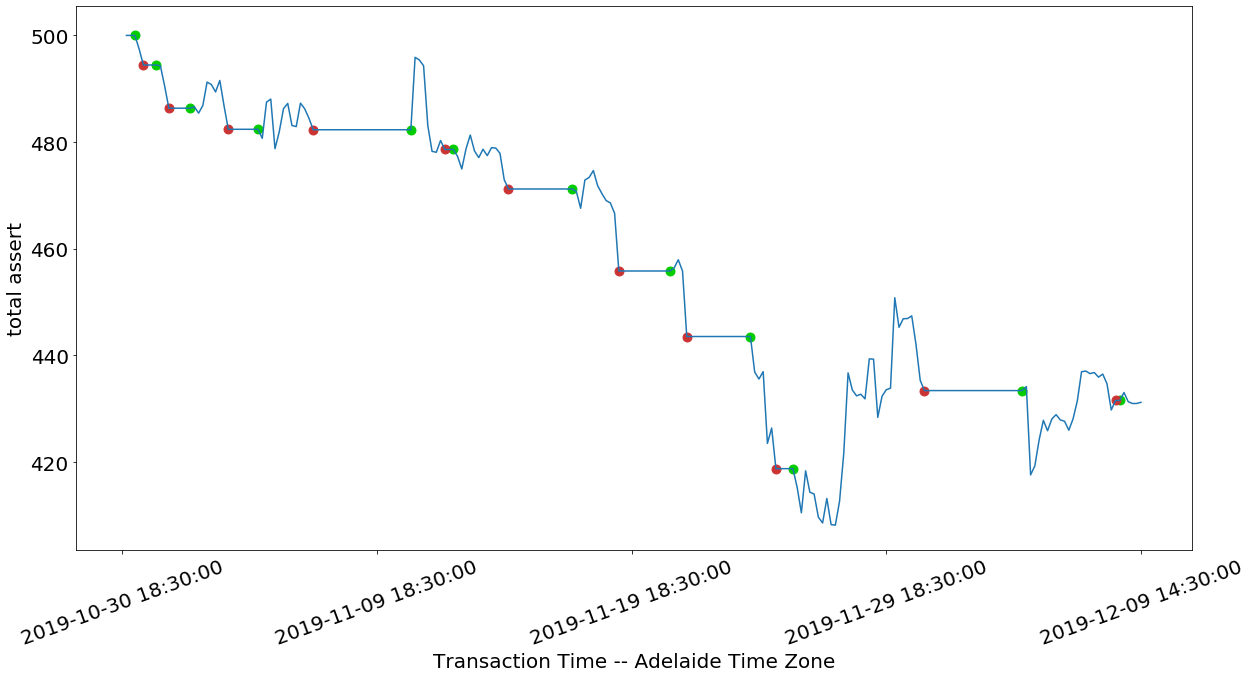

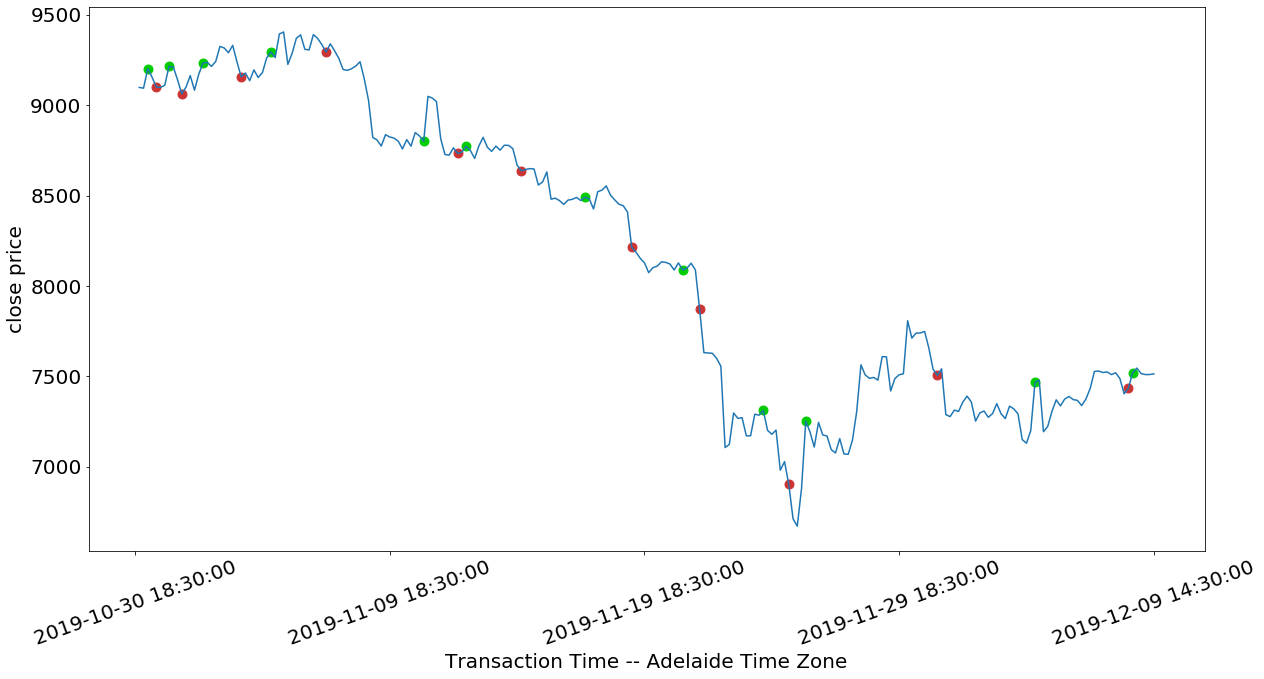

In [11]:
record = {}
run_bot('4h','4 hours','40 days ago UTC',record)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


Initial money is:500
Initial bitcoin is:0
Initial bnb is:5
Investment Start Time:2019-10-29 18:30:00
Investment End Time:2019-11-29 16:30:00
Investment Periods: 30
Current Money:422.68274759999986
Current Bitcoin: 0
Current BNB: 4.347415303787917
Return on Investment is:-15.095555412172482%
Current Total Assert is: 500.93622306818236
Trading curb occured


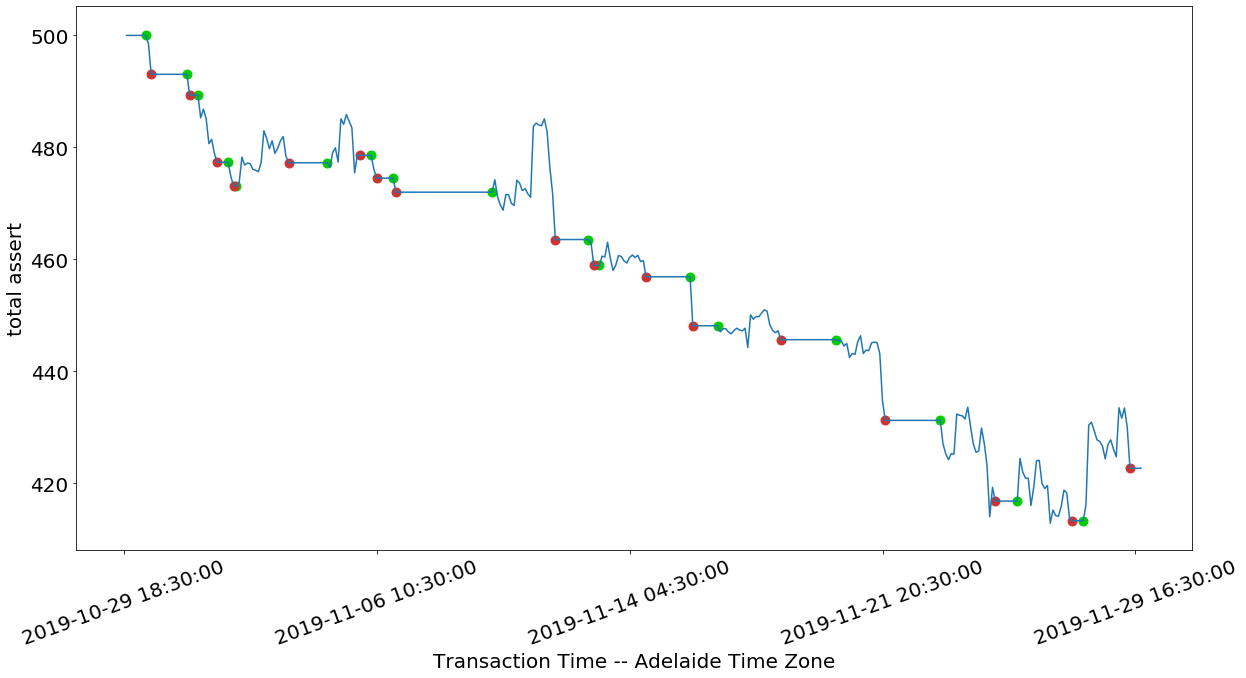

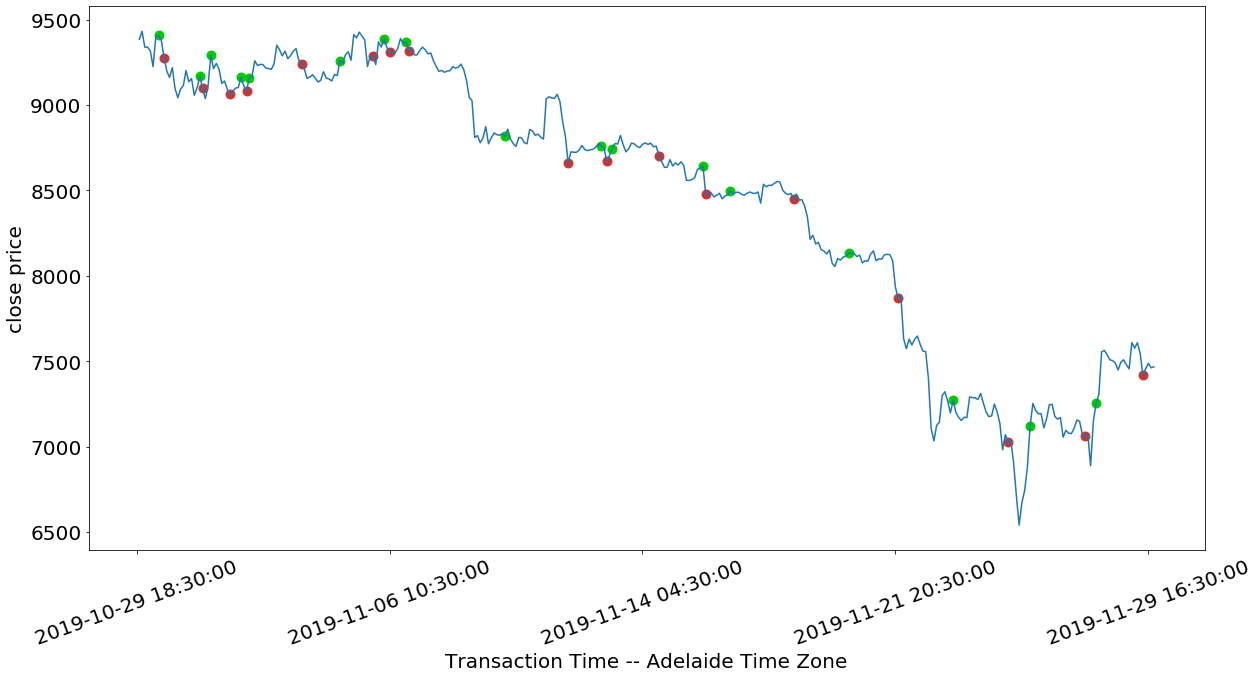

In [20]:
record = {}
run_bot('2h','2 hour','1 months ago UTC',record)